WARE HOUSE ANALYSIS - SQL / PYTHON

In [4]:
#!pip install pyodbc

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import os
import warnings
import pyodbc

warnings.filterwarnings('ignore')

Tenemos dos formas de conectarnos a la base de datos:
1 - Usando pyodbc
2 - Usando sqlalchemy
Se van a mostrar las dos pero nosostros vamos a trabajar con sqlalchemy

In [4]:
# Conexión a base de datos SQL con pyodbc
# Datos de conexión
server = 'DAVID'        # Ejemplo: 'localhost' o 'NOMBREPC\\SQLEXPRESS'
database = 'DataWarehouseAnalytics'   # Ejemplo: 'AdventureWorks'
#username = 'DAVID\\david'       # Si usas autenticación SQL Server
#password = 'TU_CONTRASEÑA'    # Si usas autenticación SQL Server

# Cadena de conexión
connection_string = (
    'DRIVER={ODBC Driver 18 for SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    'Trusted_Connection=yes;'
    'TrustServerCertificate=yes;'
)


# Conexión
conn = pyodbc.connect(connection_string)


In [6]:
# Conexión mediante sqlalchemy

from sqlalchemy import create_engine
import pandas as pd

server = 'DAVID'  # O 'localhost', etc.
database = 'DataWarehouseAnalytics'

# Si usas autenticación de Windows:
engine = create_engine(
    f"mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes&TrustServerCertificate=yes"
)

# Si usas usuario y contraseña de SQL Server:
# username = 'tu_usuario'
# password = 'tu_contraseña'
# engine = create_engine(
#     f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+18+for+SQL+Server&TrustServerCertificate=yes"
# )


In [10]:
query1 = '''
select year(order_date) as order_year,  -- podemos poner year, month
sum(sales_amount) as total_sales , 
count(DISTINCT customer_key) as total_customers, -- analizamos también los clientes
sum(quantity) as total_quantity
from gold.fact_sales
where order_date is not null
group by year(order_date)
order by year(order_date) asc
'''

df1 = pd.read_sql(query1, engine)
df1

,order_year,total_sales,total_customers,total_quantity
0,2010,43419,14,14
1,2011,7075088,2216,2216
2,2012,5842231,3255,3397
3,2013,16344878,17427,52807
4,2014,45642,834,1970


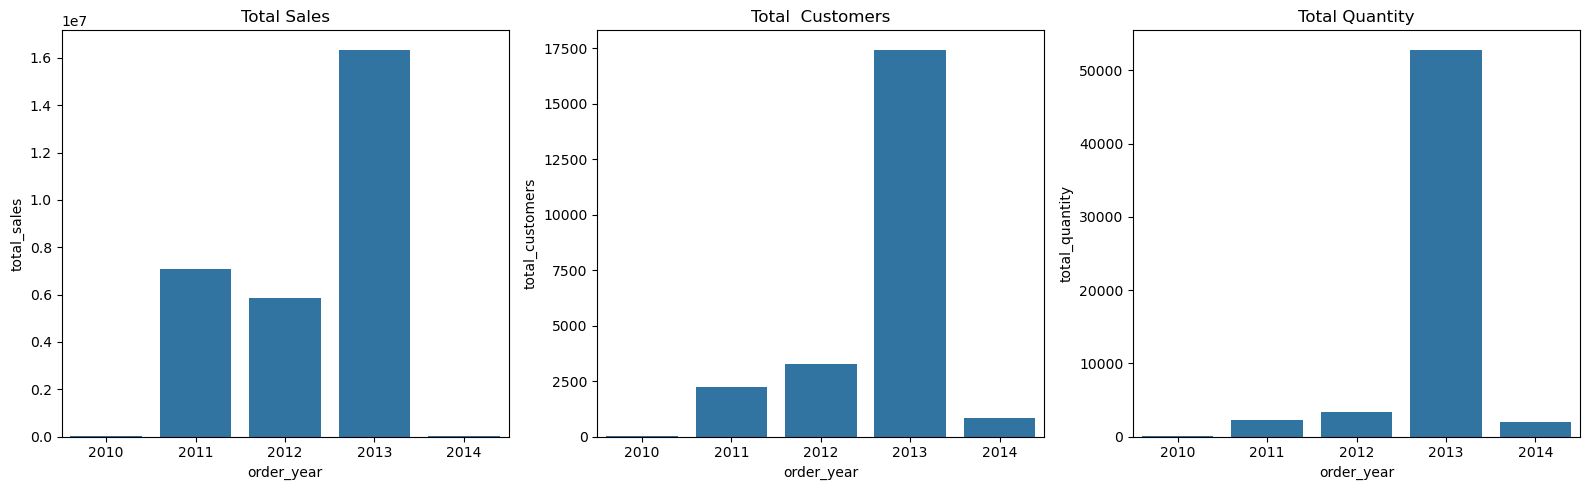

In [63]:
fig,ax=plt.subplots(1,3, figsize=(16,5))
sns.barplot(data=df1, x='order_year',y='total_sales', ax=ax[0])
ax[0].set_title('Total Sales')
sns.barplot(data=df1, x='order_year',y='total_customers', ax=ax[1])
ax[1].set_title('Total  Customers')
sns.barplot(data=df1, x='order_year',y='total_quantity', ax=ax[2])
ax[2].set_title('Total Quantity')

plt.tight_layout()


In [67]:
# a continuación realziamos el análisis por mes
query2 = '''
select datetrunc(month, order_date) as order_date,  -- podemos poner year, month
sum(sales_amount) as total_sales , 
count(DISTINCT customer_key) as total_customers, -- analizamos también los clientes
sum(quantity) as total_quantity
from gold.fact_sales
where order_date is not null
group by datetrunc(month, order_date)
order by datetrunc(month, order_date) asc
'''

df2 = pd.read_sql(query2, engine)
df2.head()

,order_date,total_sales,total_customers,total_quantity
0,2010-12-01,43419,14,14
1,2011-01-01,469795,144,144
2,2011-02-01,466307,144,144
3,2011-03-01,485165,150,150
4,2011-04-01,502042,157,157


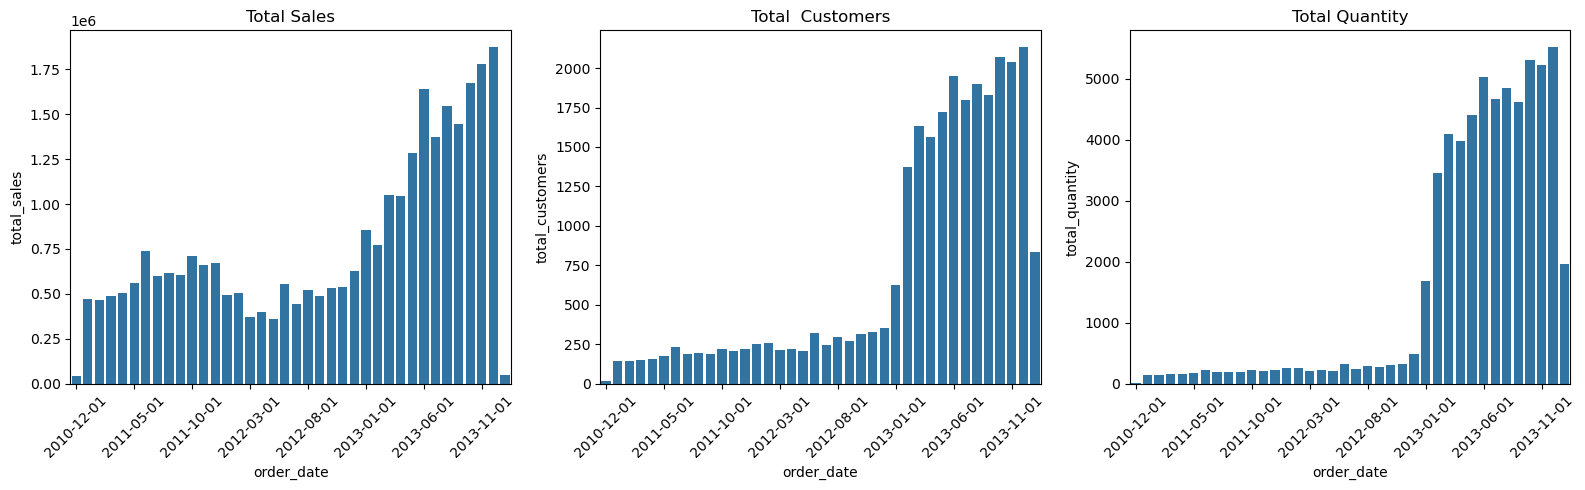

In [81]:
from matplotlib.ticker import MaxNLocator

fig,ax=plt.subplots(1,3, figsize=(16,5))
sns.barplot(data=df2, x='order_date',y='total_sales', ax=ax[0])
ax[0].set_title('Total Sales')

sns.barplot(data=df2, x='order_date',y='total_customers', ax=ax[1])
ax[1].set_title('Total  Customers')
sns.barplot(data=df2, x='order_date',y='total_quantity', ax=ax[2])
ax[2].set_title('Total Quantity')
for i in range(0,3):
    ax[i].xaxis.set_major_locator(MaxNLocator(nbins=8)) # limitamos el numero de fechas
    ax[i].tick_params(axis='x', rotation=45)

plt.tight_layout()


In [85]:
query3 = '''
select 
    order_date,
    total_sales,
    sum(total_sales) over (order by order_date) as running_total_sales
from(
    select 
        datetrunc(month, order_date) as order_date,
        sum(sales_amount) as total_sales
    from gold.fact_sales
    where order_date is not null
    group by datetrunc(month, order_date)
) t
'''

df3 = pd.read_sql(query3, engine)
df3.head()

,order_date,total_sales,running_total_sales
0,2010-12-01,43419,43419
1,2011-01-01,469795,513214
2,2011-02-01,466307,979521
3,2011-03-01,485165,1464686
4,2011-04-01,502042,1966728


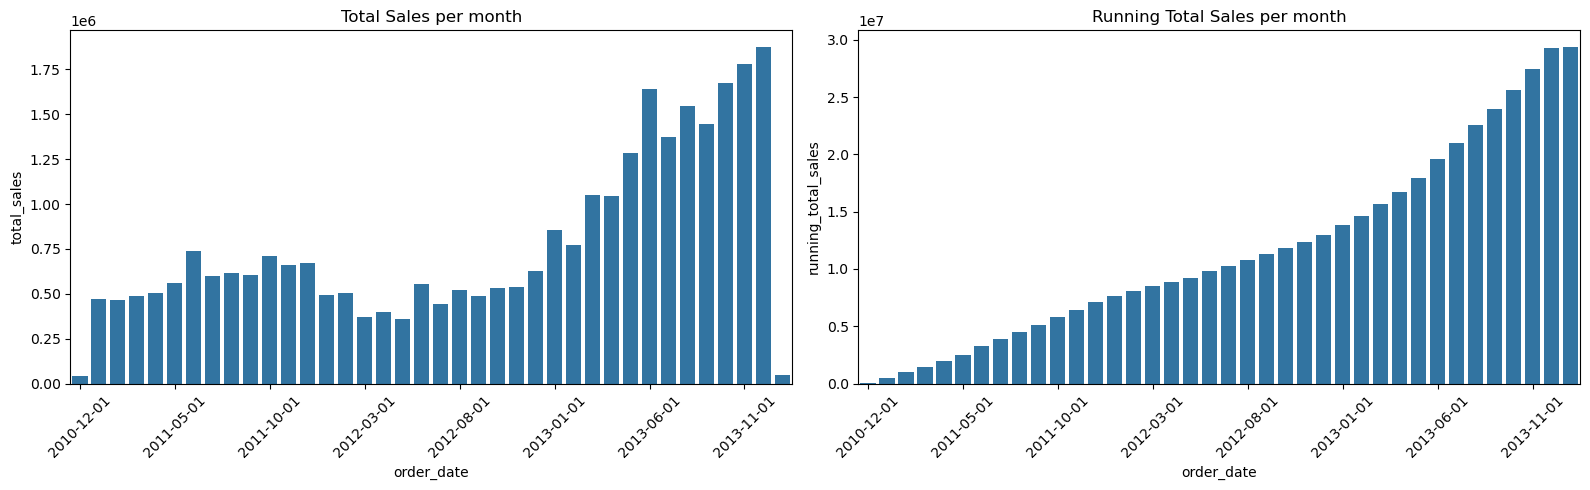

In [91]:
from matplotlib.ticker import MaxNLocator

fig,ax=plt.subplots(1,2, figsize=(16,5))
sns.barplot(data=df3, x='order_date',y='total_sales', ax=ax[0])
ax[0].set_title('Total Sales per month')

sns.barplot(data=df3, x='order_date',y='running_total_sales', ax=ax[1])
ax[1].set_title('Running Total Sales per month')
for i in range(0,2):
    ax[i].xaxis.set_major_locator(MaxNLocator(nbins=8)) # limitamos el numero de fechas
    ax[i].tick_params(axis='x', rotation=45)

plt.tight_layout()


In [89]:
# hacemos el running sales por año y variación del precio promedio
query4 = '''
select 
    order_date,
    total_sales,
    sum(total_sales) over (order by order_date) as running_total_sales,
    avg(avg_price) over(order by order_date) as moving_avg_price
from(
    select 
    datetrunc(year, order_date) as order_date,
    sum(sales_amount) as total_sales,
    avg(price) as avg_price
from gold.fact_sales
where order_date is not null
group by datetrunc(year, order_date)
) t
'''

df4 = pd.read_sql(query4, engine)
df4

,order_date,total_sales,running_total_sales,moving_avg_price
0,2010-01-01,43419,43419,3101
1,2011-01-01,7075088,7118507,3146
2,2012-01-01,5842231,12960738,2670
3,2013-01-01,16344878,29305616,2080
4,2014-01-01,45642,29351258,1668


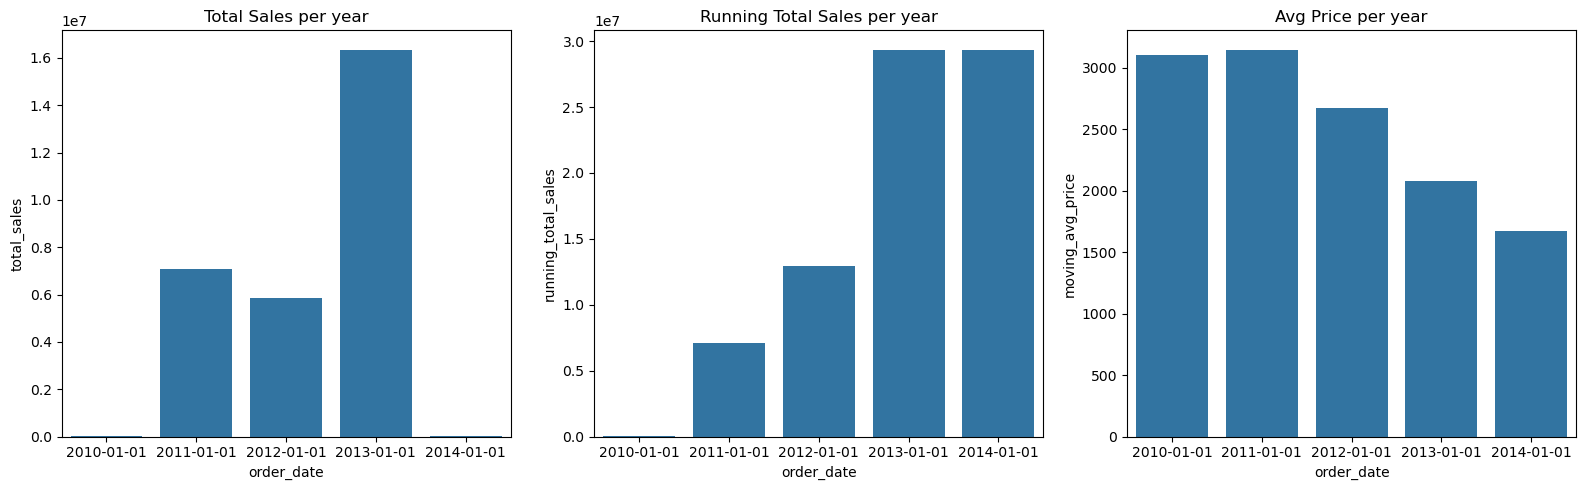

In [97]:
fig,ax=plt.subplots(1,3, figsize=(16,5))
sns.barplot(data=df4, x='order_date',y='total_sales', ax=ax[0])
ax[0].set_title('Total Sales per year')

sns.barplot(data=df4, x='order_date',y='running_total_sales', ax=ax[1])
ax[1].set_title('Running Total Sales per year')

sns.barplot(data=df4, x='order_date',y='moving_avg_price', ax=ax[2])
ax[2].set_title('Avg Price per year')

plt.tight_layout()


In [99]:
query5 = '''
with yearly_product_sales as( -- creamos una sublista temporal que contenga la info
    select 
        year(f.order_date) as order_year,
        p.product_name,
        sum(f.sales_amount) as current_sales
    from gold.fact_sales f
    left join gold.dim_products p
    on f.product_key=p.product_key
    where order_date is not null
    group by 
    year(f.order_date), p.product_name
)
select  -- aqui manejamos la tabla temporal with
    order_year,
    current_sales,
    product_name,
    current_sales,
    avg(current_sales) over (partition by product_name) as avg_sales, -- establecemeos que haga la media con particiones segun el nombre de producto
    current_sales - avg(current_sales) over (partition by product_name) as diff_avg, -- creamos una columna con la diferencia entre current sales y avg sales
    case when current_sales - avg(current_sales) over (partition by product_name) > 0 then 'Above Avg'
    	 when current_sales - avg(current_sales) over (partition by product_name) < 0 then 'Below Avg'
    	 else 'Avg'
    end avg_change
from yearly_product_sales
order by product_name, order_year
'''

df5 = pd.read_sql(query5, engine)
df5


,order_year,current_sales,product_name,current_sales,avg_sales,diff_avg,avg_change
0,2012,159,All-Purpose Bike Stand,159,13197,-13038,Below Avg
1,2013,37683,All-Purpose Bike Stand,37683,13197,24486,Above Avg
2,2014,1749,All-Purpose Bike Stand,1749,13197,-11448,Below Avg
3,2012,72,AWC Logo Cap,72,6570,-6498,Below Avg
4,2013,18891,AWC Logo Cap,18891,6570,12321,Above Avg
...,...,...,...,...,...,...,...
266,2014,1610,Women's Mountain Shorts- L,1610,12705,-11095,Below Avg
267,2013,23380,Women's Mountain Shorts- M,23380,12320,11060,Above Avg
268,2014,1260,Women's Mountain Shorts- M,1260,12320,-11060,Below Avg
269,2013,20230,Women's Mountain Shorts- S,20230,10640,9590,Above Avg


In [101]:
#ahora en vez de comparar con la media comparamos con el año previo -> Year over Year Analysis
query6 = '''
with yearly_products_sales as (
    select 
        year(f.order_date) as order_year,
        p.product_name,
        sum(f.sales_amount) as current_sales
    from gold.fact_sales f
    left join gold.dim_products p
    on f.product_key=p.product_key
    where order_date is not null
    group by  year(f.order_date), p.product_name
)
select 
    order_year,
    product_name,
    current_sales,
    avg(current_sales) over (partition by product_name) as avg_sales,
    current_sales - avg(current_sales) over (partition by product_name) as diff_avg,
    case when current_sales - avg(current_sales) over (partition by product_name) > 0 then 'Above Avg'
    	 when current_sales - avg(current_sales) over (partition by product_name) < 0 then 'Below Avg'
    	 else 'Avg'
    end avg_change,
    lag(current_sales) over (partition by product_name order by order_year) as py_sales, -- comparamos con la columna anterior , ahora ya tenemos los dos datos
    current_sales - lag(current_sales) over (partition by product_name order by order_year) as diff_py, -- de nuevo calculamos la diferencia
    case when current_sales - lag(current_sales) over (partition by product_name order by order_year) > 0 then 'Increase'
    	 when current_sales - lag(current_sales) over (partition by product_name order by order_year) < 0 then 'Decrease'
    	 else 'No Change'
    end py_change
from yearly_products_sales
order by product_name, order_year
'''

df6 = pd.read_sql(query6, engine)
df6


,order_year,product_name,current_sales,avg_sales,diff_avg,avg_change,py_sales,diff_py,py_change
0,2012,All-Purpose Bike Stand,159,13197,-13038,Below Avg,NaN,NaN,No Change
1,2013,All-Purpose Bike Stand,37683,13197,24486,Above Avg,159.0,37524.0,Increase
2,2014,All-Purpose Bike Stand,1749,13197,-11448,Below Avg,37683.0,-35934.0,Decrease
3,2012,AWC Logo Cap,72,6570,-6498,Below Avg,NaN,NaN,No Change
4,2013,AWC Logo Cap,18891,6570,12321,Above Avg,72.0,18819.0,Increase
...,...,...,...,...,...,...,...,...,...
266,2014,Women's Mountain Shorts- L,1610,12705,-11095,Below Avg,23800.0,-22190.0,Decrease
267,2013,Women's Mountain Shorts- M,23380,12320,11060,Above Avg,NaN,NaN,No Change
268,2014,Women's Mountain Shorts- M,1260,12320,-11060,Below Avg,23380.0,-22120.0,Decrease
269,2013,Women's Mountain Shorts- S,20230,10640,9590,Above Avg,NaN,NaN,No Change


In [ ]:
#which catgories contibutes the most to overall sales

In [105]:
query7 = '''
WITH category_sales AS (
    SELECT 
        p.category,
        SUM(f.sales_amount) AS total_sales
    FROM gold.fact_sales f
    LEFT JOIN gold.dim_products p
        ON f.product_key = p.product_key
    GROUP BY p.category
)
SELECT
    category,
    total_sales,
    SUM(total_sales) OVER () AS overall_sales, -- suma total
    CONCAT(ROUND((CAST(total_sales AS float) / SUM(total_sales) OVER ()) * 100, 2), '%') AS percentage_of_total
FROM category_sales
ORDER BY total_sales DESC
'''

df7 = pd.read_sql(query7, engine)
df7


,category,total_sales,overall_sales,percentage_of_total
0,Bikes,28316272,29356250,96.46%
1,Accessories,700262,29356250,2.39%
2,Clothing,339716,29356250,1.16%


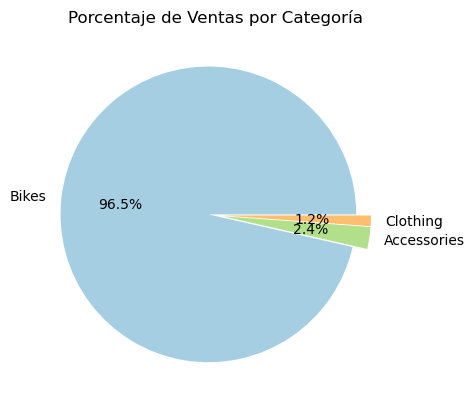

In [129]:
colors = ['#a6cee3', '#b2df8a', '#fdbf6f']
plt.pie(df7['total_sales'], 
    labels=df7['category'], 
    autopct='%1.1f%%',
    colors=colors,
    explode=(0.05, 0.05, 0.05),  # Separa un poco cada porción para mejor visualización
)

plt.title('Porcentaje de Ventas por Categoría')
plt.show()

In [12]:
# 5. Data segmentation

In [16]:
# Primero vamos a categorizar los productos según rangos de costes 

query8 = '''
with product_segments as (
    select 
        product_key,
        product_name,
        cost,
        case when cost < 100 then 'Below'
        	 when cost between 100 and 500 then '100-500'
        	 when cost between 500 and 1000 then '500-1000'
        	 else 'Above 1000'
        end cost_range
    from gold.dim_products
)
select 
    cost_range,
    count(product_key) as total_products
from product_segments
group by cost_range
order by total_products desc
'''

df8 = pd.read_sql(query8, engine)
df8


,cost_range,total_products
0,Below,110
1,100-500,101
2,500-1000,45
3,Above 1000,39


([<matplotlib.patches.Wedge at 0x1d2f43330e0>,
 [Text(0.42770660267001526, 1.0134431715851038, 'Below'),
  Text(-1.0581024373756993, -0.30069790823948983, '100-500'),
  Text(0.28375794816627375, -1.06277063699204, '500-1000'),
  Text(1.006481902040372, -0.4438402650337116, 'Above 1000')],
 [Text(0.233294510547281, 0.5527871845009656, '37.3%'),
  Text(-0.5771467840231086, -0.16401704085790353, '34.2%'),
  Text(0.15477706263614932, -0.5796930747229309, '15.3%'),
  Text(0.5489901283856573, -0.24209469001838813, '13.2%')])

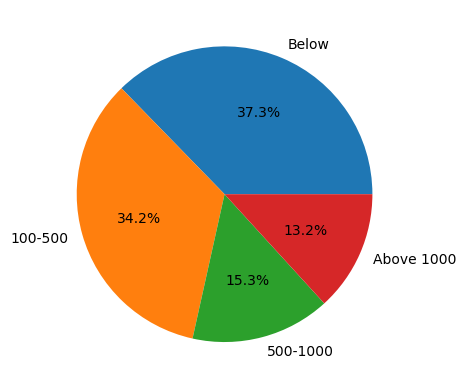

In [34]:
plt.pie(df7['total_products'], labels=df7['cost_range'], autopct='%1.1f%%')

In [38]:
# a contiunaución realizamos una categorizacion de clientes: 
# Agrupamos clientes en tres segmentos según su comportamiento de gasto:
	#- VIP: clientes con al menos 12 meses y con un historial de gasto mayoir a 5000
	#- Regular: Clientes con al menos 12 meses de historial pero que han gastado menos de 5000
	#- New: clientes con menos de 12 meses de historial
#Encontrar el número de clientes de cada grupo

In [40]:
query9 = '''
with customer_spending as( 
    select 
        c.customer_key,
        sum(f.sales_amount) as total_spending,
        min(order_date) as first_order, -- Determinamos la primera y ultima fecha de pedidos
        max(order_date) as last_order,
        datediff(month, min(order_date), max(order_date)) as lifespan --calculamos la difercnia en meses entre el primer y ultimo pedido
    from gold.fact_sales f
    left join gold.dim_customers c
    on f.customer_key=c.customer_key
    group by c.customer_key
)
select 
    customer_key,
    total_spending,
    lifespan,
    case when lifespan >= 12 and total_spending > 5000 then 'VIP'
    	 when lifespan >= 12 and total_spending <= 5000 then 'Regular'
    	 else 'New'
    end as customer_segment
from customer_spending
'''

df9 = pd.read_sql(query9, engine)
df9

,customer_key,total_spending,lifespan,customer_segment
0,11407,3018,13.0,Regular
1,14324,1715,0.0,New
2,5834,2344,0.0,New
3,2917,2355,0.0,New
4,15675,69,0.0,New
...,...,...,...,...
18479,6492,127,3.0,New
18480,11902,5971,28.0,VIP
18481,4328,40,0.0,New
18482,15148,79,0.0,New


In [76]:
# agrupamos por número de clientes
df9_count=df9.groupby('customer_segment')['customer_key'].count().reset_index()

In [78]:
df9_count

,customer_segment,customer_key
0,New,14631
1,Regular,2198
2,VIP,1655


([<matplotlib.patches.Wedge at 0x1d2f455d3a0>,
 [Text(-0.8724420109050869, 0.6699589074024529, 'New'),
  Text(0.6521774174926359, -0.8858129690361484, 'Regular'),
  Text(1.0567684240750386, -0.30535307085071145, 'VIP')],
 [Text(-0.4758774604936837, 0.3654321313104288, '79.2%'),
  Text(0.355733136814165, -0.4831707103833536, '11.9%'),
  Text(0.5764191404045664, -0.1665562204640244, '9.0%')])

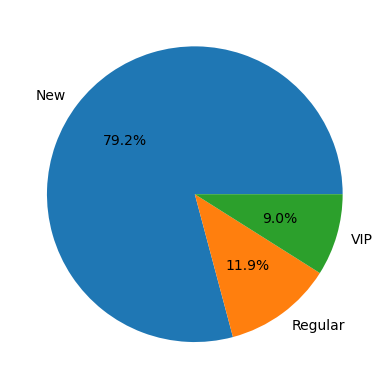

In [80]:
plt.pie(df9_count['customer_key'], labels=df9_count['customer_segment'], autopct='%1.1f%%')

In [82]:
# 6. Build Customer Report

In [84]:
# creamos el sigueinte customer report: 

query10 = '''
WITH base_query AS(
/*---------------------------------------------------------------------------
1) Base Query: Retrieves core columns from tables
---------------------------------------------------------------------------*/
SELECT
f.order_number,
f.product_key,
f.order_date,
f.sales_amount,
f.quantity,
c.customer_key,
c.customer_number,
CONCAT(c.first_name, ' ', c.last_name) AS customer_name,
DATEDIFF(year, c.birthdate, GETDATE()) age
FROM gold.fact_sales f
LEFT JOIN gold.dim_customers c
ON c.customer_key = f.customer_key
WHERE order_date IS NOT NULL)

, customer_aggregation AS (
/*---------------------------------------------------------------------------
2) Customer Aggregations: Summarizes key metrics at the customer level
---------------------------------------------------------------------------*/
SELECT 
	customer_key,
	customer_number,
	customer_name,
	age,
	COUNT(DISTINCT order_number) AS total_orders,
	SUM(sales_amount) AS total_sales,
	SUM(quantity) AS total_quantity,
	COUNT(DISTINCT product_key) AS total_products,
	MAX(order_date) AS last_order_date,
	DATEDIFF(month, MIN(order_date), MAX(order_date)) AS lifespan
FROM base_query
GROUP BY 
	customer_key,
	customer_number,
	customer_name,
	age
)
SELECT
customer_key,
customer_number,
customer_name,
age,
CASE 
	 WHEN age < 20 THEN 'Under 20'
	 WHEN age between 20 and 29 THEN '20-29'
	 WHEN age between 30 and 39 THEN '30-39'
	 WHEN age between 40 and 49 THEN '40-49'
	 ELSE '50 and above'
END AS age_group,
CASE 
    WHEN lifespan >= 12 AND total_sales > 5000 THEN 'VIP'
    WHEN lifespan >= 12 AND total_sales <= 5000 THEN 'Regular'
    ELSE 'New'
END AS customer_segment,
last_order_date,
DATEDIFF(month, last_order_date, GETDATE()) AS recency,
total_orders,
total_sales,
total_quantity,
total_products
lifespan,
-- Compuate average order value (AVO)
CASE WHEN total_sales = 0 THEN 0
	 ELSE total_sales / total_orders
END AS avg_order_value,
-- Compuate average monthly spend
CASE WHEN lifespan = 0 THEN total_sales
     ELSE total_sales / lifespan
END AS avg_monthly_spend
FROM customer_aggregation
'''

df10 = pd.read_sql(query10, engine)
df10

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend
0,1,AW00011000,Jon Yang,54.0,50 and above,VIP,2013-05-03,144,3,8249,8,8,2749,294
1,2,AW00011001,Eugene Huang,49.0,40-49,VIP,2013-12-10,137,3,6384,11,10,2128,182
2,3,AW00011002,Ruben Torres,54.0,50 and above,VIP,2013-02-23,147,3,8114,4,4,2704,324
3,4,AW00011003,Christy Zhu,52.0,50 and above,VIP,2013-05-10,144,3,8139,9,9,2713,280
4,5,AW00011004,Elizabeth Johnson,46.0,40-49,VIP,2013-05-01,144,3,8196,6,6,2732,292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18477,18480,AW00029479,Tommy Tang,56.0,50 and above,New,2012-09-04,152,1,2049,1,1,2049,2049
18478,18481,AW00029480,Nina Raji,48.0,40-49,New,2013-07-17,142,1,2442,5,5,2442,2442
18479,18482,AW00029481,Ivan Suri,60.0,50 and above,New,2011-08-13,165,1,3375,1,1,3375,3375
18480,18483,AW00029482,Clayton Zhang,61.0,50 and above,New,2012-09-18,152,1,2049,1,1,2049,2049


In [86]:
# tenemos un nuevo df report sobre la infromación de los clientes a partir del cual podemos trabajar de nuevo

In [104]:
df10_a=df10.groupby('age_group').agg({
    'total_sales':'sum',
    'customer_number':'count'
}
).reset_index()

In [98]:
df10_a

,age_group,total_sales,customer_number
0,30-39,279917,196
1,40-49,9566103,6103
2,50 and above,19505238,12183


In [102]:
df10_b=df10.groupby('customer_segment').agg({
    'total_sales':'sum',
    'customer_number':'count'
}
).reset_index()

In [106]:
df10_b

,customer_segment,total_sales,customer_number
0,New,11086797,14629
1,Regular,7503991,2200
2,VIP,10760470,1653


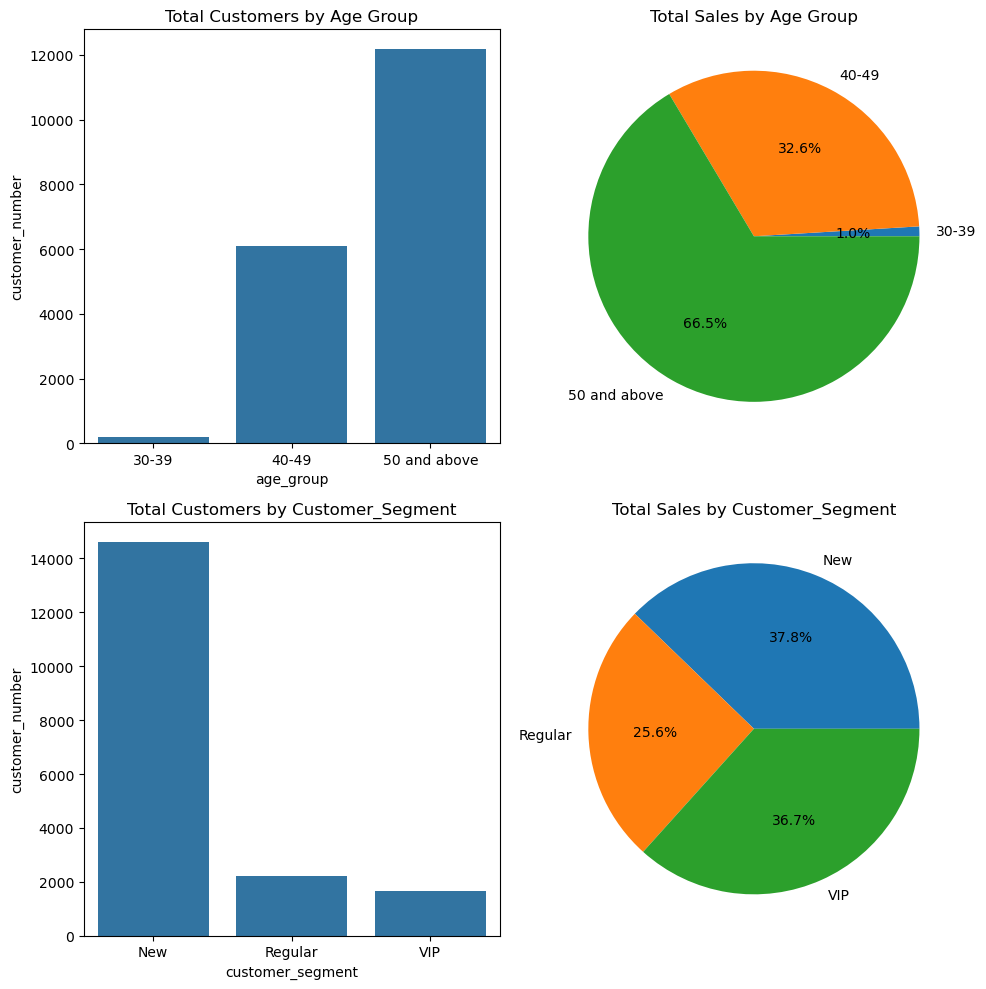

In [134]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

# Gráfico de barras
sns.barplot(data=df10_a, x='age_group', y='customer_number', ax=ax[0])
ax[0].set_title('Total Customers by Age Group')
# Gráfico de pastel
ax[1].pie(df10_a['total_sales'], labels=df10_a['age_group'], autopct='%1.1f%%')
ax[1].set_title('Total Sales by Age Group')
# Gráfico de barras
sns.barplot(data=df10_b, x='customer_segment', y='customer_number', ax=ax[2])
ax[2].set_title('Total Customers by Customer_Segment')
# Gráfico de pastel
ax[3].pie(df10_b['total_sales'], labels=df10_b['customer_segment'], autopct='%1.1f%%')
ax[3].set_title('Total Sales by Customer_Segment')

plt.tight_layout()
plt.show()

In [ ]:
# 7. Build Product Report

In [8]:


query11 = '''
with base_query as (

    select 
        f.order_number,
        f.order_date,
        f.customer_key,
        f.sales_amount,
        f.quantity,
        p.product_key,
        p.product_name,
        p.category,
        p.subcategory,
        p.cost
    from gold.fact_sales f
    left join gold.dim_products p
    on f.product_key=p.product_key
    where order_date is not null
)

, product_aggregation as (
    select
        product_key,
        product_name,
        category,
        subcategory,
        cost,
        datediff(month, min(order_date), max(order_date)) as lifespan,
        max(order_date) as last_sale_date,
        count(distinct order_number) as total_orders,
        count(distinct customer_key) as total_customers,
        sum(sales_amount) as total_sales,
        sum(quantity) as total_quantity,
        round(avg(sales_amount/nullif(quantity, 0)),1) as avg_selling_price
    from base_query

    GROUP BY
        product_key,
        product_name,
        category,
        subcategory,
        cost

)

select 
    product_key,
    product_name,
    category,
    subcategory,
    cost,
    last_sale_date,
    datediff(month, last_sale_date , getdate()) as recency_in_months,
    case when total_sales > 50000 then 'High-Performer'
    	 when total_sales >= 10000 then 'Mid_Range'
    	 else 'Low_Performer'
    end as product_segment,
    lifespan,
    total_orders,
    total_sales,
    total_quantity,
    total_customers,
    avg_selling_price,
    -- Average Order Revenue
    case when total_orders = 0 then 0
    	 else total_sales/total_orders
    end as avg_order_revenue,
    -- Average Monthly Revenue
    case when lifespan = 0 then total_sales
    	 else total_sales / lifespan
    end as avg_monthly_revenue
from product_aggregation
'''

df11 = pd.read_sql(query11, engine)
df11

,product_key,product_name,category,subcategory,cost,last_sale_date,recency_in_months,product_segment,lifespan,total_orders,total_sales,total_quantity,total_customers,avg_selling_price,avg_order_revenue,avg_monthly_revenue
0,3,Mountain-100 Black- 38,Bikes,Mountain Bikes,1898,2011-12-27,161,High-Performer,11,49,165375,49,49,3375,3375,15034
1,4,Mountain-100 Black- 42,Bikes,Mountain Bikes,1898,2011-12-27,161,High-Performer,11,45,151875,45,45,3375,3375,13806
2,5,Mountain-100 Black- 44,Bikes,Mountain Bikes,1898,2011-12-21,161,High-Performer,11,60,202500,60,60,3375,3375,18409
3,6,Mountain-100 Black- 48,Bikes,Mountain Bikes,1898,2011-12-26,161,High-Performer,12,57,192375,57,57,3375,3375,16031
4,7,Mountain-100 Silver- 38,Bikes,Mountain Bikes,1912,2011-12-22,161,High-Performer,12,58,197200,58,58,3400,3400,16433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,291,Touring Tire Tube,Accessories,Tires and Tubes,2,2014-01-28,136,Low_Performer,13,1487,7435,1487,1410,5,5,571
126,292,Classic Vest- L,Clothing,Vests,24,2014-01-28,136,Mid_Range,12,195,12480,195,195,64,64,1040
127,293,Classic Vest- M,Clothing,Vests,24,2014-01-27,136,Mid_Range,12,199,12736,199,199,64,64,1061
128,294,Classic Vest- S,Clothing,Vests,24,2014-01-28,136,Mid_Range,13,168,10944,171,168,64,65,841


In [14]:
df11_a=df11.groupby('product_segment').agg({
    'total_sales':'sum',
    'product_name':'count'
}).reset_index().rename(columns={'product_name':'number_products'})

<Axes: xlabel='product_segment', ylabel='total_sales'>

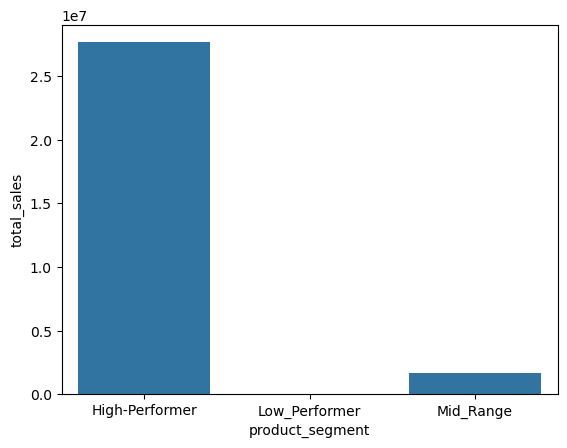

In [26]:
sns.barplot(data=df11_a, x='product_segment', y='total_sales')

<Axes: xlabel='product_segment', ylabel='number_products'>

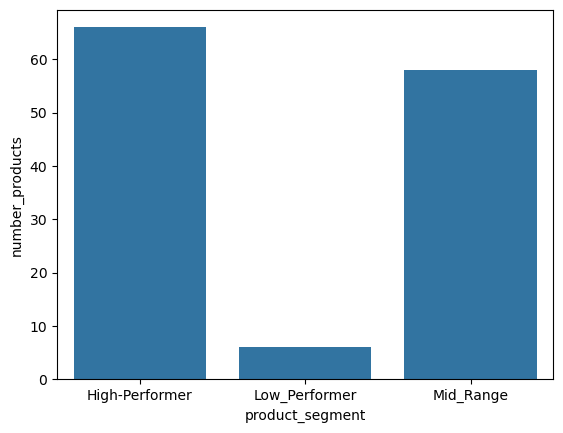

In [28]:
sns.barplot(data=df11_a, x='product_segment', y='number_products')

In [36]:
# top 10 products by total sales
df11.sort_values(by='total_sales', ascending=False).head(5)

,product_key,product_name,category,subcategory,cost,last_sale_date,recency_in_months,product_segment,lifespan,total_orders,total_sales,total_quantity,total_customers,avg_selling_price,avg_order_revenue,avg_monthly_revenue
46,122,Mountain-200 Black- 46,Bikes,Mountain Bikes,1252,2013-12-27,137,High-Performer,24,620,1373454,620,600,2215,2215,57227
45,121,Mountain-200 Black- 42,Bikes,Mountain Bikes,1252,2013-12-28,137,High-Performer,23,614,1363128,614,604,2220,2220,59266
47,123,Mountain-200 Silver- 38,Bikes,Mountain Bikes,1266,2013-12-28,137,High-Performer,23,596,1339394,596,583,2247,2247,58234
49,125,Mountain-200 Silver- 46,Bikes,Mountain Bikes,1266,2013-12-28,137,High-Performer,23,579,1298709,579,566,2243,2243,56465
44,120,Mountain-200 Black- 38,Bikes,Mountain Bikes,1252,2013-12-28,137,High-Performer,24,581,1292559,581,564,2224,2224,53856


In [38]:
# top 10 products by total orders
df11.sort_values(by='total_orders', ascending=False).head(5)

,product_key,product_name,category,subcategory,cost,last_sale_date,recency_in_months,product_segment,lifespan,total_orders,total_sales,total_quantity,total_customers,avg_selling_price,avg_order_revenue,avg_monthly_revenue
129,295,Water Bottle - 30 oz.,Accessories,Bottles and Cages,2,2014-01-28,136,Mid_Range,13,4244,21245,4249,4073,5,5,1634
104,259,Patch Kit/8 Patches,Accessories,Tires and Tubes,1,2014-01-28,136,Low_Performer,13,3189,6378,3189,2948,2,2,490
123,289,Mountain Tire Tube,Accessories,Tires and Tubes,2,2014-01-28,136,Mid_Range,13,3092,15465,3093,2958,5,5,1189
124,290,Road Tire Tube,Accessories,Tires and Tubes,1,2014-01-28,136,Low_Performer,13,2375,9500,2375,2225,4,4,730
98,246,Sport-100 Helmet- Red,Accessories,Helmets,13,2014-01-28,136,High-Performer,13,2230,78050,2230,2147,35,35,6003
